In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


**We started with a dataset containing 76 features and performed data cleaning by handling missing values and removing irrelevant features. Using a pipelined preprocessing approach, we imputed both numerical and categorical features and applied feature selection to retain the most relevant ones. To identify the best-performing model, we trained three tree-based classifiers—RandomForest, XGBoost, and LightGBM—before selecting the optimal model for generating predictions.**

In [2]:
df_train = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
df_test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [3]:
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Summary of dataset
print("Dataset Overview:")
print(df_train.info())
print("\nMissing Values:\n", df_train.isnull().sum())

# Statistical summary of numerical features
selected_num_cols = num_cols[:3]
print("\nNumerical Feature Statistics (First 3 Features):")
print(df_train[selected_num_cols].describe())

# Statistical summary of categorical features
print("\nCategorical Feature Distribution:")
for col in cat_cols:
    unique_values = df_train[col].nunique()
    
    # Only display the top 3 most frequent values
    top_values = df_train[col].value_counts().head(3)
    
    print(f"{col} - Unique Values: {unique_values}")
    print(top_values, "\n" + "-"*40)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm   

CLEANING DATA 

In [4]:
df_train.rename(columns=lambda x: x.strip(), inplace=True)
df_test.rename(columns=lambda x: x.strip(), inplace=True)

# Drop MachineID , DateAS and DateOS (Unrelated features)
df_train.drop(columns=['MachineID','DateAS', 'DateOS'], inplace=True,errors='ignore')
df_test.drop(columns=['MachineID','DateAS', 'DateOS'], inplace=True, errors='ignore')


In [5]:
#Identified all column types to run the code faster
num_cols = [
    'IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID',
    'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID', 'GeoRegionID',
    'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected', 'AutoSampleSubmissionEnabled',
    'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount',
    'ProcessorManufacturerID', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
    'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
    'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges', 'OSBuildNumberOnly', 'OSBuildRevisionOnly',
    'OSInstallLanguageID', 'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled', 'FirmwareManufacturerID',
    'FirmwareVersionID', 'IsSecureBootEnabled', 'IsVirtualDevice', 'IsTouchEnabled', 'IsPenCapable',
    'IsAlwaysOnAlwaysConnectedCapable', 'IsGamer', 'RegionIdentifier'
]
cat_cols = [
    'ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion',
    'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType',
    'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition',
    'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
    'FlightRing', 
]

ENCODE FEATURES

In [6]:
# Outlier Handling
# Outlier Handling: Cap values instead of removing them
def capOutliers(df, columns, factor=1.5):
    for col in columns:
        if df[col].isnull().all():  # Skip columns with all NaN values
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Apply clipping only to non-null values
        df[col] = df[col].where(df[col].isnull() | ((df[col] >= lower_bound) & (df[col] <= upper_bound)),  
                                df[col].clip(lower=lower_bound, upper=upper_bound))
    
    return df

df_train = capOutliers(df_train, num_cols)

X = df_train.drop(columns=['target'])
y = df_train['target']
X_test = df_test.copy()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/

PIPELINING NUMERICAL AND CATEGORICAL FEATURES

In [7]:
num_pipeline = Pipeline([ #Numerical pipeline - handles missing values, restricts outliers and normalizes.
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_capper', FunctionTransformer(
        lambda X: capOutliers(pd.DataFrame(X, columns=num_cols), num_cols, factor=1.5)
    )),  
    ('scaler', MinMaxScaler())  
])


cat_pipeline = Pipeline([ #Categorical pipeline
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value',  
        unknown_value=-1  
    ))
])

preprocessor = ColumnTransformer([ #Column transformer
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

FEATURE SELECTION AND TRAIN - TEST SPLIT

In [8]:
# Apply preprocessing to the full dataset before train-test split
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

# Feature Selection using XGBoost
xgb_feature_selector = XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
xgb_feature_selector.fit(X_processed, y)

importances = xgb_feature_selector.feature_importances_
important_indices = np.argsort(importances)[-int(0.95 * len(importances)):]  

X_selected = X_processed[:, important_indices]
X_test_selected = X_test_processed[:, important_indices]

# Now, perform Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

MODEL CHOOSING

In [9]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=400, max_depth=20, min_samples_split=5, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=18, learning_rate=0.02, subsample=0.95, colsample_bytree=0.95, gamma=0.4, reg_lambda=2.0, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=400, max_depth=25, learning_rate=0.03, num_leaves=100, subsample=0.85, colsample_bytree=0.85, min_child_weight=5, reg_alpha=0.7, reg_lambda=1.5, random_state=42)
}

best_model = None
best_metric = 0
MODEL_PATH = "best_model.pkl"

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='weighted')
    print(f"{name} Validation F1 Score: {val_f1:.4f}")
    
    if val_f1 > best_metric:
        best_metric = val_f1
        best_model = model

with open(MODEL_PATH, "wb") as file:
    pickle.dump(best_model, file)

print(f"Best model selected: {best_model.__class__.__name__} with F1 Score: {best_metric:.4f}")

Training RandomForest...
RandomForest Validation F1 Score: 0.6193
Training XGBoost...
XGBoost Validation F1 Score: 0.6210
Training LightGBM...
[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4120
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
LightGBM Validation F1 Score: 0.6279
Best model selected: LGBMClassifier with F1 Score: 0.6279


**As LIGHTGBM gives the best F1 score, we select the that model to predict the test dataset.**
* LightGBM is optimized for large datasets and efficiently handles thousands of features, as seen in your dataset with 231 used features.
* Unlike RandomForest (which uses depth-wise growth), LightGBM grows leaf-wise, making it more accurate and efficient for structured data.
* The model automatically optimized for multi-threading, allowing for faster training times compared to XGBoost.

SAVE PREDICTION IN CSV

In [10]:
predictions = model.predict(X_test_selected)
submission = pd.DataFrame({"id": range(len(predictions)), "target": predictions})
submission.to_csv("/kaggle/working/submission.csv", index=False)

EXPLORATORY DATA ANALYSIS

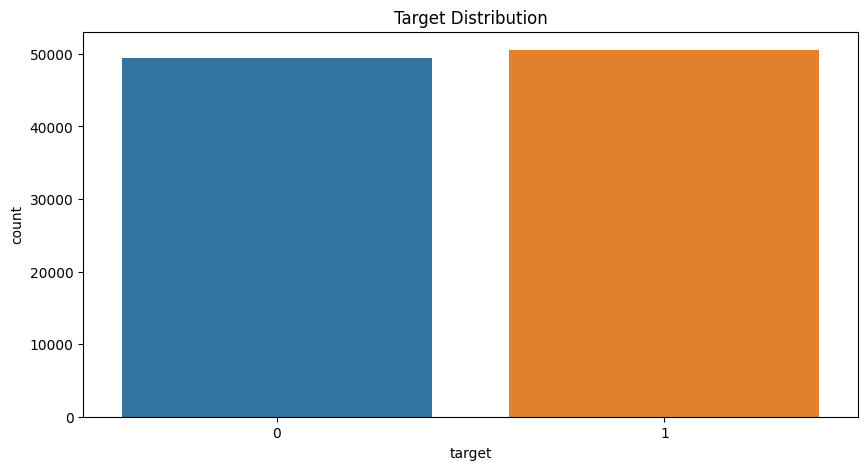

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


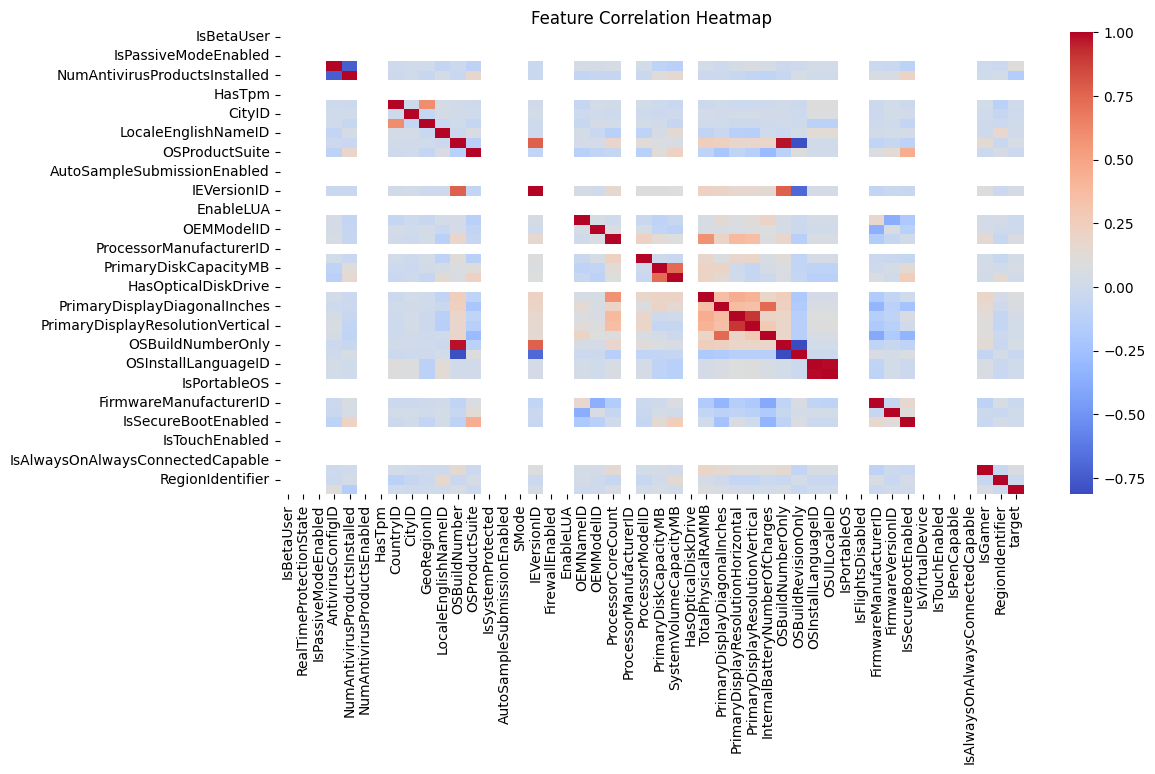

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


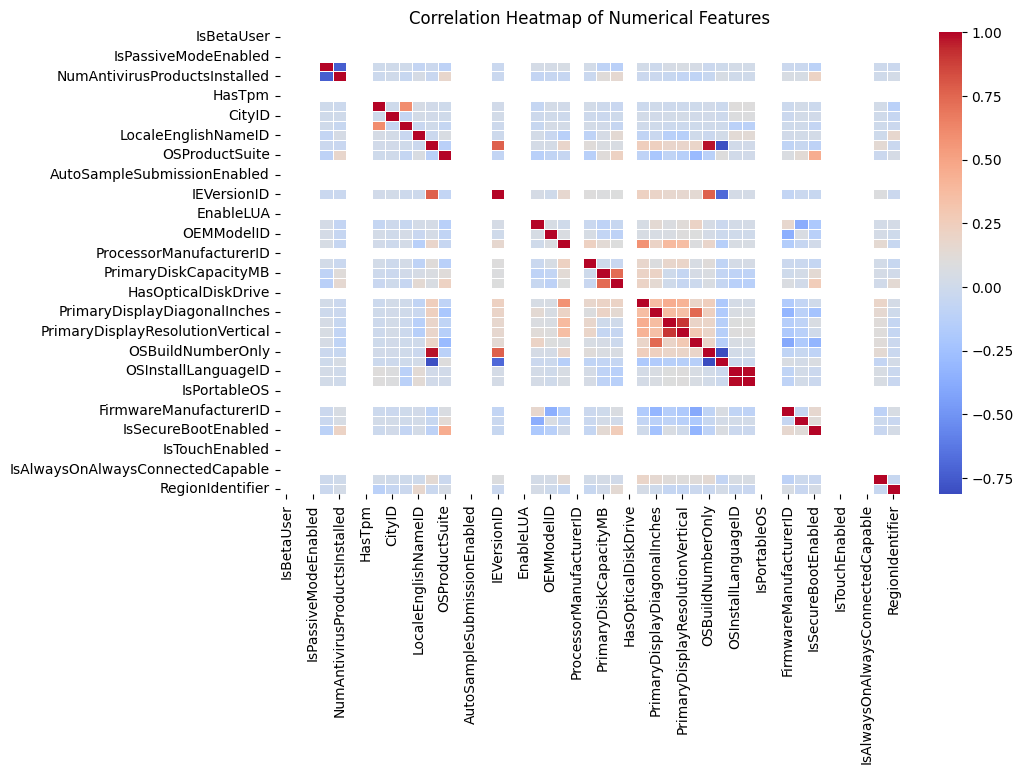

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

# Compute and plot correlation matrix
numeric_df = df_train.select_dtypes(include=[float, int])

plt.figure(figsize=(12, 6))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
# Correlation heatmap of numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(df_train[num_cols].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Visualising data using charts

Visual representation of some columns for reference


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


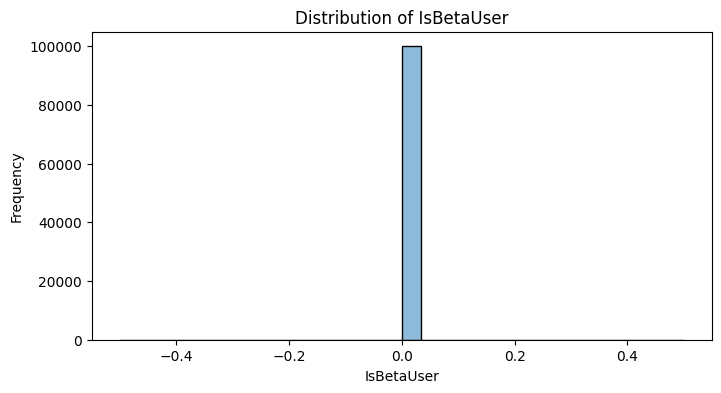

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


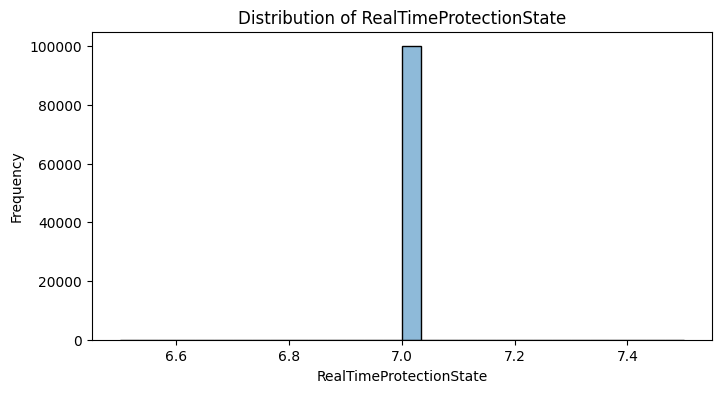

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


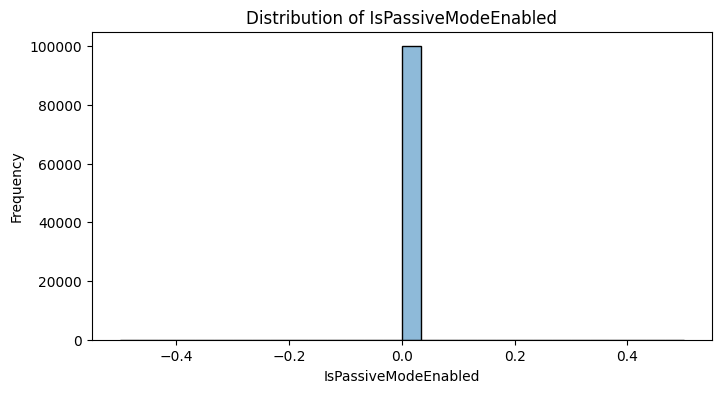

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


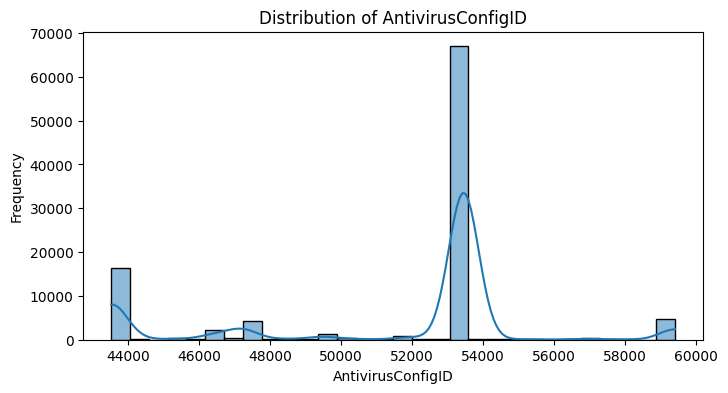

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


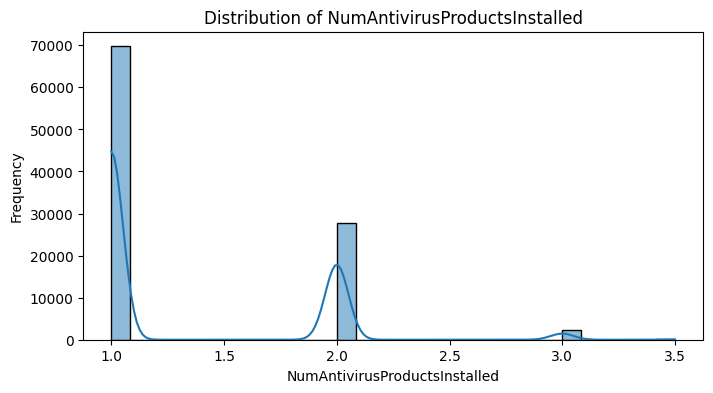

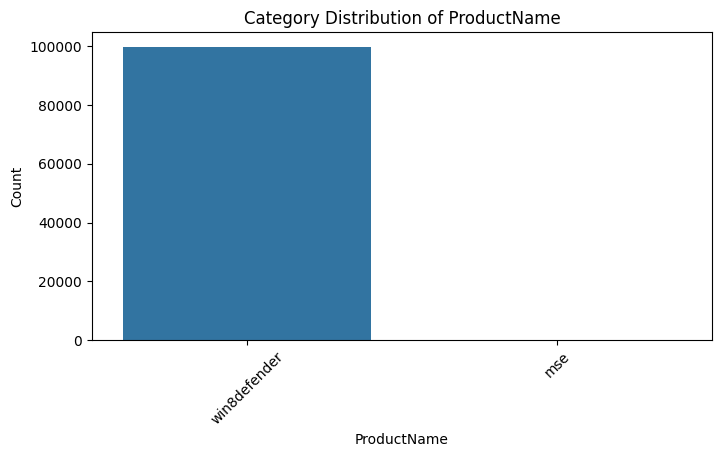

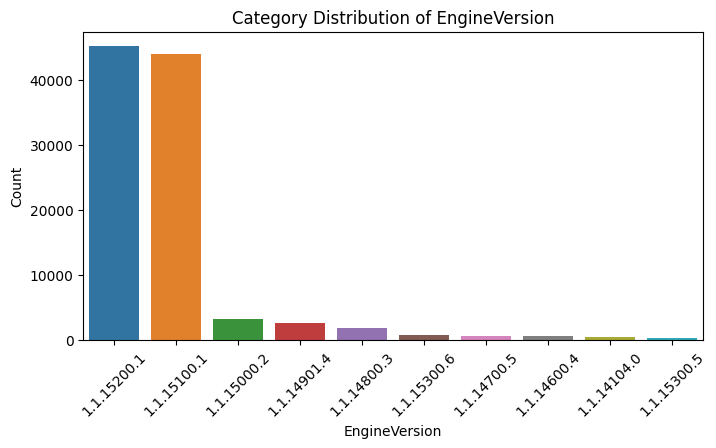

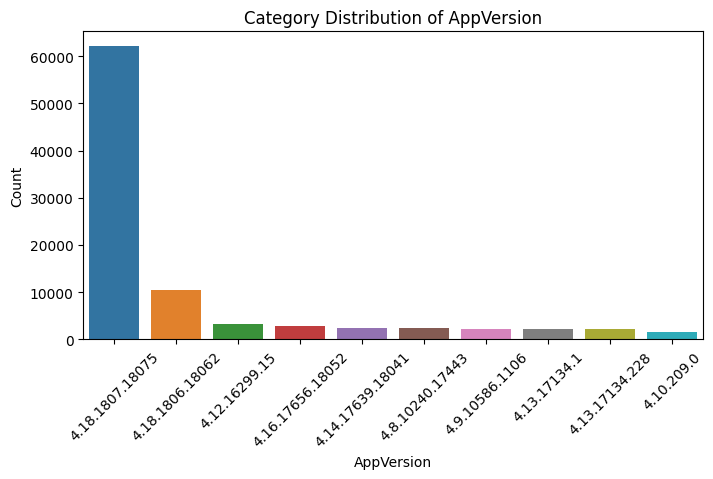

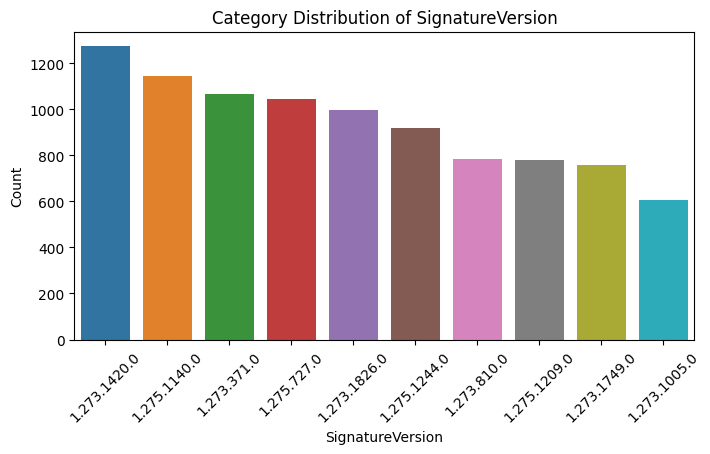

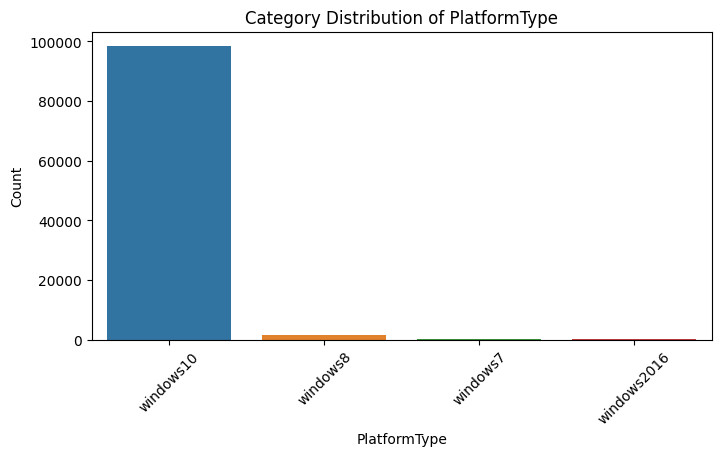

In [12]:
print("Visual representation of some columns for reference")
# Visualize distributions for first 5 numerical features
for col in num_cols[:5]:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Visualize distributions for first 5 categorical features
for col in cat_cols[:5]:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df_train[col], order=df_train[col].value_counts().index[:10])
    plt.title(f"Category Distribution of {col}")
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

MileStone 1